In [2]:
# 1. Importando librerías necesarias
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y preprocesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV,KFold

# Métricas
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    roc_auc_score
)

# Ignorar advertencias para mantener el output limpio
warnings.filterwarnings('ignore')

# Importar funciones personalizadas
# %run "../Modelado/Funciones_Cuota.py"


In [ ]:
#2. Funciones para el modelado

def entrenar_modelo_binario_final(modelo, X, y, nombre_modelo="Modelo"):
    """
    Entrena y evalúa un modelo de clasificación binaria con validación hold-out.

    Esta función divide los datos en conjuntos de entrenamiento y prueba, 
    entrena el modelo proporcionado, genera predicciones y calcula métricas 
    clave de rendimiento (reporte de clasificación, matriz de confusión, 
    puntuación ROC AUC). Además, muestra visualmente la matriz de confusión 
    y la curva ROC.

    Parámetros:
    -----------
    modelo : sklearn.base.BaseEstimator
        Modelo de clasificación binaria ya instanciado (por ejemplo, RandomForestClassifier).
    
    X : array-like, shape (n_samples, n_features)
        Conjunto de características (features).
    
    y : array-like, shape (n_samples,)
        Etiquetas/clases objetivo (binarias).

    nombre_modelo : str, opcional (default="Modelo")
        Nombre que se mostrará en los títulos de las visualizaciones.

    Retorna:
    --------
    modelo : sklearn.base.BaseEstimator
        El modelo entrenado (ajustado con los datos de entrenamiento).
    """

    print(f"\n📌 Entrenando y evaluando: {nombre_modelo}")
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.20, stratify=y)

    # Entrenamiento
    modelo.fit(X_train, y_train)

    # Predicción
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]

    # Métricas
    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print("\n🧮 Matriz de Confusión:")
    print(cm)
    print(f"\n📈 ROC AUC Score: {roc_auc:.4f}")

    # Visualizaciones
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
    plt.title(f'Matriz de Confusión - {nombre_modelo}')
    plt.show()

    # Retornar modelo entrenado
    return modelo

def correr_cross_validate(X, y, n_splits=5, random_state=42):
    """
    Ejecuta validación cruzada con modelos de clasificación binaria predefinidos.

    Parámetros:
    -----------
    X : DataFrame
        Variables predictoras.
    y : Series
        Variable objetivo binaria.
    n_splits : int
        Número de folds para StratifiedKFold.
    random_state : int
        Semilla de aleatoriedad para reproducibilidad.

    Retorna:
    --------
    df_resultados : DataFrame
        Tabla con métricas promedio por modelo.
    """
    
    # -----------------------------
    # Definir modelos internamente
    # -----------------------------
    modelos = {
        'LogisticRegression': Pipeline([
            ('scaler', StandardScaler()),
            ('clf', LogisticRegression(max_iter=1000, random_state=random_state))]),
        
        'RandomForest': RandomForestClassifier(random_state=random_state),
        
        'GradientBoosting': GradientBoostingClassifier(random_state=random_state),
        
        'DecisionTree': DecisionTreeClassifier(random_state=random_state),
        
        'SVM': Pipeline([
            ('scaler', StandardScaler()),
            ('clf', SVC(probability=True, random_state=random_state))]),
        
        'KNN': Pipeline([
            ('scaler', StandardScaler()),
            ('clf', KNeighborsClassifier())
        ])
    }

    # -----------------------------
    # Métricas y estrategia de CV
    # -----------------------------
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    resultados = []

    # -----------------------------
    # Evaluar cada modelo
    # -----------------------------
    for nombre, modelo in modelos.items():
        print(f"🧪 Evaluando modelo: {nombre}")
        modelo_cv = clone(modelo)  # evitar contaminación entre iteraciones

        cv_result = cross_validate(
            modelo_cv, X, y, cv=cv,n_jobs=-1, scoring=scoring, return_train_score=False
        )

        resultados.append({
            'Modelo': nombre,
            'Accuracy': np.mean(cv_result['test_accuracy']),
            'Precision': np.mean(cv_result['test_precision']),
            'Recall': np.mean(cv_result['test_recall']),
            'F1': np.mean(cv_result['test_f1']),
            'ROC_AUC': np.mean(cv_result['test_roc_auc']),
            'STD_ROC_AUC': np.std(cv_result['test_roc_auc']),
            'Det_ROC_AUC': cv_result['test_roc_auc'].tolist()
        })

    df_resultados = pd.DataFrame(resultados).sort_values(by='ROC_AUC', ascending=False)
    display(df_resultados)
    return df_resultados

def seleccion_parametros_Grid(X, y, modelos_param_grid, n_splits=3, test_size=0.2, random_state=42):
    """
    Ejecuta GridSearchCV + cross-validation para modelos y grids personalizados.

    Parámetros:
    -----------
    X : DataFrame
        Variables predictoras.
    y : Series
        Variable objetivo binaria.
    modelos_param_grid : dict
        Diccionario con modelos a evaluar y sus grids.
        Estructura: {'nombre': {'pipeline': ..., 'param_grid': {...}}}
    n_splits : int
        Número de particiones para StratifiedKFold.
    test_size : float
        Proporción del test split (solo para validación cruzada interna).
    random_state : int
        Semilla de aleatoriedad.

    Retorna:
    --------
    df_resultados : DataFrame con métricas por modelo.
    mejores_modelos_dict : dict con los mejores modelos y sus parámetros.
    """

    # -----------------------------
    # División train/test
    # -----------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=random_state, test_size=test_size, stratify=y
    )

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # -----------------------------
    # Métricas
    # -----------------------------
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }

    resultados = []
    mejores_modelos_dict = {}

    # -----------------------------
    # Evaluar cada modelo
    # -----------------------------
    for nombre, config in modelos_param_grid.items():
        print(f"\n🔍 Buscando mejores parámetros para: {nombre}")

        grid = GridSearchCV(
            estimator=config['pipeline'],
            param_grid=config['param_grid'],
            cv=cv,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=0,
            return_train_score=False
        )
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_

        # Cross-validation con mejores parámetros
        cv_result = cross_validate(
            best_model, X_train, y_train,
            cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1
        )

        resultados.append({
            'Modelo': nombre,
            'Mejores parámetros': grid.best_params_,
            'Mejor estimador': best_model,

            'ROC_AUC': np.mean(cv_result['test_roc_auc']),
            'STD_ROC_AUC': np.std(cv_result['test_roc_auc']),
            'Det_ROC_AUC': cv_result['test_roc_auc'].tolist(),

            'Accuracy': np.mean(cv_result['test_accuracy']),
            'Precision': np.mean(cv_result['test_precision']),
            'Recall': np.mean(cv_result['test_recall']),
            'F1': np.mean(cv_result['test_f1'])
              })
        
        mejores_modelos_dict[nombre] = {
            'modelo_entrenado': best_model,
            'mejores_parametros': grid.best_params_}

    df_resultados = pd.DataFrame(resultados).sort_values(by='ROC_AUC', ascending=False)
    return df_resultados, mejores_modelos_dict

def unir_filas(row):
    if row['Mod1Paga']==1:
        if row['Mod2Atraso']==1:
            if row['Mod3Vencida']==1:
                return 4
            else:
                return 3
        else:
            return 2
    else:
        return row['Mod1Paga']+1
def prob_final(row):
        if pd.isna(row['Mod3Prob']):
            if pd.isna(row['Mod2Prob']):
                return row['Mod1Prob']
            else:
                return row['Mod2Prob']
        else:
            return row['Mod3Prob']

def obtener_target(x):
    if x==900:
        return 1
    elif x<=0:
        return 2
    elif x<=10:
        return 3
    elif x>10:
        return 4
    
def pipeline_pago_atraso_dias(X,  modelo_1, cols_1,
                                  modelo_2, cols_2,
                                  modelo_3, cols_3):
    """
    Pipeline jerárquico con 3 modelos, cada uno usando su set de variables.

    Parámetros:
    -----------
    X : DataFrame
        Dataset completo.
    modelo_1 : modelo sklearn
        Modelo para predecir pago (paga / no paga)
    cols_1 : list
        Columnas a usar en modelo_1

    modelo_2 : modelo sklearn
        Modelo para predecir atraso (sin / con)
    cols_2 : list
        Columnas a usar en modelo_2

    modelo_3 : modelo sklearn
        Modelo para predecir nivel de atraso (<=10 / >10 días o regresión)
    cols_3 : list
        Columnas a usar en modelo_3

    Retorna:
    --------
    DataFrame con las predicciones en cada etapa.
    """

    resultados = pd.DataFrame(index=X.index)
    #Transformacion de variables
        #AreaPrograma
    X['AreaProgramaConstruccion']=(X['AreaPrograma']=='Construcción').astype('int')
        #VersionPrograma
    orden = ['Sin Version','Basica', 'Profesional', 'Gerencial']
    X['VersionPrograma_Ordinal'] = pd.Categorical(X['VersionPrograma'],categories=orden, ordered=True)
    X['VersionPrograma_Ordinal']=X['VersionPrograma_Ordinal'].cat.codes
        #Compromisos Cuota Anterior
    X['CompromisosCuotaAnterior']=(X['TotalCompromisosCuotaAnterior']>0).astype('int')
        #Pais agrupado
    X['NombrePais']=X['NombrePais'].map({'Perú':1,'Colombia':3,'Mexico':2}).fillna(4)

    # 1ER MODELO: paga o no paga
    X1 = X[cols_1]
    resultados['Mod1Paga'] = modelo_1.predict(X1)
    resultados['Mod1Prob'] = modelo_1.predict_proba(X1)[:, 1]
    # Inicializar columnas vacías
    resultados['Mod2Atraso'] = np.nan
    resultados['Mod3Vencida'] = np.nan
    resultados['Mod2Prob'] = np.nan
    resultados['Mod3Prob'] = np.nan

    # Filtrar los que pagan
    idx_paga = resultados[resultados['Mod1Paga'] == 1].index
    X2 = X.loc[idx_paga, cols_2]

    # 2DO MODELO: sin / con atraso
    resultados.loc[idx_paga, 'Mod2Atraso'] = modelo_2.predict(X2)
    resultados.loc[idx_paga, 'Mod2Prob'] = modelo_2.predict_proba(X2)[:, 1]

    # Filtrar los que pagan con atraso
    idx_atraso = resultados[(resultados['Mod1Paga'] == 1) & (resultados['Mod2Atraso'] == 1)].index
    X3 = X.loc[idx_atraso, cols_3]

    # 3ER MODELO: predicción de nivel de atraso (clasificación o regresión)
    resultados.loc[idx_atraso, 'Mod3Vencida'] = modelo_3.predict(X3)
    resultados.loc[idx_atraso, 'Mod3Prob'] = modelo_3.predict_proba(X3)[:, 1]

    resultados['Pred_Final']=resultados.apply(unir_filas,axis=1)
    resultados['Prob_Final']=resultados.apply(prob_final,axis=1).round(3)

    resultados=pd.concat([X,resultados],axis=1)
    resultados=resultados.drop(columns=['Mod1Paga','Mod2Atraso','Mod3Vencida','Mod1Prob','Mod2Prob','Mod3Prob'])
    return resultados


In [4]:
# 3. Importar la base de datos desde un archivo .pickle
data=pd.read_pickle(r'..\Resultado\DataCumplimientoCuota_7days_CreandoVar1.pickle')

In [5]:
#4. Imputacion a las variables con valores nulos y limpieza de atipicos
#PagosUltimos30Dias
data['PagosUltimos30Dias']=data['PagosUltimos30Dias'].fillna(0)
# MesDesdeUltimoPago: Se imputa con el valor maximo de los dias del ultimo pago 520, luego se convierte en valor entero
data['DiasDesdeUltimoPago']=data['DiasDesdeUltimoPago'].fillna(180)
data['MesDesdeUltimoPago']=np.ceil(data['DiasDesdeUltimoPago']/30).astype('int')
data['MesDesdeUltimoPago']=data['MesDesdeUltimoPago'].apply(lambda x: 17 if x>16 else x)
data['MesDesdeUltimoPago']=data['MesDesdeUltimoPago'].apply(lambda x: 1 if x==0 else x)
#MesUltimoAvance: Se imputa con el valor del numero de cuotas para el mes
data['DiasUltimoAvance']=data['DiasUltimoAvance'].fillna(data['NroCuota']*30)
data['MesUltimoAvance']=np.ceil(data['DiasUltimoAvance']/30).astype('int')
data['MesUltimoAvance']=data['MesUltimoAvance'].apply(lambda x: 17 if x>17 else x)
data['MesUltimoAvance']=data['MesUltimoAvance'].apply(lambda x: 1 if x==0 else x)
data['AñoFV']=(data.FechaVencimientoReal).dt.year
data.drop(columns=['DiasDesdeUltimoPago','DiasUltimoAvance'],inplace=True)

#DiasAtrasoPromedio: Imputacion de variables de atraso con 100 dias
data['DiasAtrasoPromedio']=data['DiasAtrasoPromedio'].fillna(100)
data['DiasAtrasoPromedio']=data['DiasAtrasoPromedio'].astype('int')
data['DiasAtrasoPromedio']=data['DiasAtrasoPromedio'].apply(lambda x: 100 if x>100 else x)

In [6]:
# 5. Definiendo la target de los modelos

# TARGET: Modelo 1
# Crea la variable objetivo para el Modelo 1: 'Mod1Paga'
# Si 'AtrasoDias' no es nulo, significa que existe información sobre el pago, por lo que se asigna 1.
# Si es nulo, se asigna 0.
data['Mod1Paga'] = (data['AtrasoDias'].notna()).astype('int')
target_Mod1 = 'Mod1Paga'  # Nombre de la variable objetivo para el Modelo 1

# TARGET: Modelo 2
# Crea la variable objetivo para el Modelo 2: 'Mod2Atraso'
# Si 'AtrasoDias' es mayor que 0, significa que hubo atraso (1), si no, 0.
data['Mod2Atraso'] = (data['AtrasoDias'] > 0).astype('int')
target_Mod2 = 'Mod2Atraso'  # Nombre de la variable objetivo para el Modelo 2


# 6. LIMPIEZA DE DATOS POR EVALUAR

## Base de datos sin primera cuota
# Filtrar para eliminar las filas correspondientes a la primera cuota (NroCuota != 1)
data = data[data.NroCuota != 1]  # Tamaño después del filtro

# Imputar valores nulos de 'AtrasoDias' con 900 (valor especial que marca 'sin dato')
data.AtrasoDias.fillna(900, inplace=True)

# Filtrar:
# Mantener solo registros con 'AtrasoDias' >= -6 días (pequeño adelanto permitido)
# o que tengan el valor 900 (sin dato imputado)
data = data[(data.AtrasoDias >= -6) | (data.AtrasoDias == 900)]

# Mantener solo registros con 'AtrasoDias' <= 90 días (máximo atraso permitido)
# o con valor 900 (sin dato imputado)
data = data[(data.AtrasoDias <= 90) | (data.AtrasoDias == 900)]

# Filtrar registros para que el intervalo entre cuotas esté entre 20 y 40 días
data = data[(data.DiasEntreCuotas >= 20) & (data.DiasEntreCuotas <= 40)]

# Filtrar por año de fecha de vencimiento:
# Mantener registros con año entre 2022 y 2025 inclusive,
# y que la fecha de vencimiento real sea menor al 31 de mayo de 2025
data = data[(data['AñoFV'] <= 2025) &
    (data['AñoFV'] >= 2022) &
    (data['FechaVencimientoReal'] < pd.to_datetime('2025-05-31'))]

In [7]:
#Seleccion de columnas
colum_seleccionadas=['CodigoMatricula', 'NroCuota', 'CuotasImpagasPrevias', '%MontoPagadoPrograma',
       'VersionPrograma', 'NombrePais','Modalidad', #----No son utiles
       'TasaContactabilidad','ActividadesTotales','PctAvanzado',
       'MinutosTotales', 'CWhatsAppEnviados', 'TotalCompromisosCuotaAnterior','CCorreosEnviados','ActividadesEfectivas', #No son utiles
       'NroCuotasPagadasConsecutivas', 'ContactoEfectivoUltimos7D',#,'MesDesdeUltimoPago',
       'DesfaseEntreAvanceYPago','MesVencimientoCuota', 'MesUltimoAvance',#'PagosUltimos30Dias' ,
        'AreaPrograma', # --No son utiles
        'DiasAtrasoPromedio','DiasEntreCuotas', 'NumCuotasRestantes',  #Eliminados por diferenciar muy poco
       'TotalCuotasSinAtraso','PagosUltimos30Dias',
       'AtrasoDias']

  #Modelo 1
colum_selec_mod1=['NroCuota', 'CuotasImpagasPrevias', '%MontoPagadoPrograma',
       'TasaContactabilidad','PctAvanzado','NumCuotasRestantes','TotalCuotasSinAtraso',
       'PagosUltimos30Dias' , 'MesUltimoAvance','VersionPrograma_Ordinal','AreaProgramaConstruccion']

  #Transformacion Variables Mod 1
    #AreaPrograma
data['AreaProgramaConstruccion']=(data['AreaPrograma']=='Construcción').astype('int')
    #VersionPrograma
orden = ['Sin Version','Basica', 'Profesional', 'Gerencial']
data['VersionPrograma_Ordinal'] = pd.Categorical(data['VersionPrograma'],categories=orden, ordered=True)
data['VersionPrograma_Ordinal']=data['VersionPrograma_Ordinal'].cat.codes

In [8]:
# 7. Separación de datos para la validación final (Año 2025)

# Se crea una copia de 'data' para la validación final
df_val = data.copy()

# Filtrar registros para la base de validación:
# - Se toman solo cuotas con FechaVencimiento entre el 01-oct-2024 y el 30-ene-2025
df_val = df_val[
    (df_val['FechaVencimiento'] <= pd.to_datetime('2025-01-30')) &
    (df_val['FechaVencimiento'] >= pd.to_datetime('2024-10-01'))]

# Filtrar registros para la base de entrenamiento:
# - Se incluyen solo cuotas con FechaVencimiento hasta el 30-sep-2024
df_entrenamiento = data[data['FechaVencimiento'] <= pd.to_datetime('2024-09-30')]



📌 Entrenando y evaluando: Random Forest Final

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1624
           1       0.96      0.98      0.97      5709

    accuracy                           0.95      7333
   macro avg       0.94      0.91      0.92      7333
weighted avg       0.95      0.95      0.95      7333


🧮 Matriz de Confusión:
[[1374  250]
 [ 123 5586]]

📈 ROC AUC Score: 0.9703


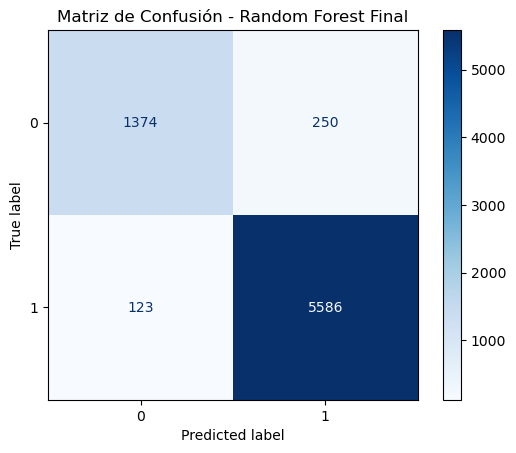

In [9]:
# 8. Entrenamiento del Modelo 1

# Filtrar el conjunto de entrenamiento para quedarnos únicamente
# con las variables seleccionadas para el Modelo 1 y la variable objetivo
data_mod1 = df_entrenamiento[colum_selec_mod1 + [target_Mod1]]

# Separar variables predictoras (X) y variable objetivo (y)
X_mod1 = data_mod1[colum_selec_mod1]   # Variables de entrada para el modelo
y_mod1 = data_mod1[target_Mod1]        # Variable objetivo: "Mod1Paga"

# Definir el algoritmo de clasificación
# Usaremos Random Forest con:
# - 200 árboles (n_estimators=200)
# - Profundidad máxima de 10 niveles (max_depth=10) para controlar sobreajuste
# - random_state=42 para asegurar resultados reproducibles
rf_mod1 = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

# Entrenar el modelo
# Se utiliza la función personalizada 'entrenar_modelo_binario_final'
# para ajustar el Random Forest a los datos de entrenamiento
# y devolver el modelo final entrenado.
Mod1_Paga = entrenar_modelo_binario_final(
    rf_mod1,
    X_mod1,
    y_mod1,
    nombre_modelo="Random Forest Final"
)


#### Modelo 2


📌 Entrenando y evaluando: Logistic Regression Final

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.83      0.75      2867
           1       0.79      0.63      0.70      2842

    accuracy                           0.73      5709
   macro avg       0.74      0.73      0.73      5709
weighted avg       0.74      0.73      0.73      5709


🧮 Matriz de Confusión:
[[2382  485]
 [1062 1780]]

📈 ROC AUC Score: 0.7907


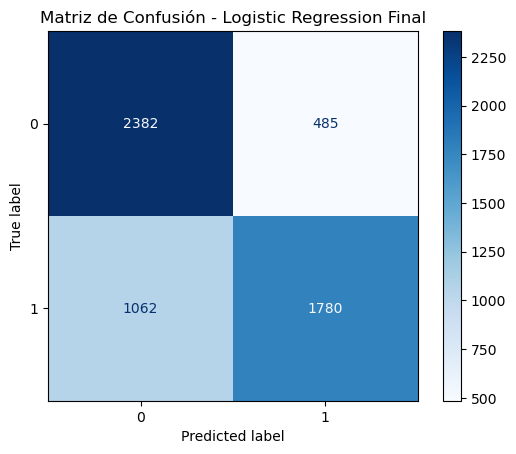

In [10]:
# 9. Entrenamiento del Modelo 2

# Variables seleccionadas para el Modelo 2
colum_selec_mod2 = [
    'NroCuota', 'CuotasImpagasPrevias', '%MontoPagadoPrograma',
    'ActividadesTotales', 'TasaContactabilidad', 'PctAvanzado',
    'TotalCuotasSinAtraso', 'TotalCompromisosCuotaAnterior']

# Filtrar el conjunto de entrenamiento para incluir solo los casos
# donde el Modelo 1 predice que se paga (Mod1Paga == 1)
# Esto significa que el Modelo 2 solo se entrena con cuotas "pagadas"
# para luego predecir si habrá atraso o no.
data_mod2 = df_entrenamiento[df_entrenamiento.Mod1Paga == 1]

# Transformación de variables
# Se crea una nueva variable binaria 'CompromisosCuotaAnterior':
# - 1 si hubo algún compromiso en la cuota anterior (TotalCompromisosCuotaAnterior > 0)
# - 0 en caso contrario
data_mod2['CompromisosCuotaAnterior'] = (
    data_mod2['TotalCompromisosCuotaAnterior'] > 0
).astype('int')

# Separación de variables predictoras (X) y objetivo (y)
X_mod2 = data_mod2[colum_selec_mod2]  # Variables de entrada
y_mod2 = data_mod2[target_Mod2]       # Variable objetivo: "Mod2Atraso"

# Definición del modelo
# Se utiliza una Regresión Logística con:
# - Escalado previo de variables (StandardScaler)
# - Penalización L2 (Ridge)
# - Parámetro C=10 (controla fuerza de regularización, más alto = menos regularización)
# - Solver 'lbfgs' para optimización eficiente
# - Máximo de 1000 iteraciones para asegurar convergencia
modelo_lr = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        C=10,
        penalty='l2',
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    ))
])

# Entrenamiento del modelo
# Se ajusta el pipeline (escalado + regresión logística) usando la función personalizada
Mod2_Atraso = entrenar_modelo_binario_final(
    modelo_lr,
    X_mod2,
    y_mod2,
    'Logistic Regression Final')

####  Modelo 3


📌 Entrenando y evaluando: Gradient Boosting Final

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      1870
           1       0.70      0.51      0.59       972

    accuracy                           0.76      2842
   macro avg       0.74      0.70      0.71      2842
weighted avg       0.75      0.76      0.75      2842


🧮 Matriz de Confusión:
[[1652  218]
 [ 475  497]]

📈 ROC AUC Score: 0.7850


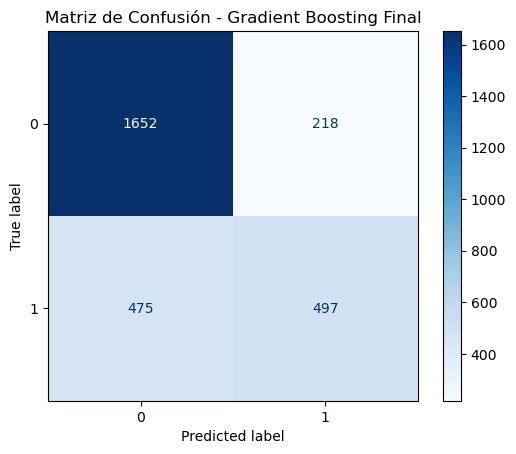

In [11]:
# 10. Entrenamiento del Modelo 3
# ==============================

# Filtrar para el Modelo 3:
# A partir de los datos usados en el Modelo 2, 
# nos quedamos únicamente con las cuotas que el Modelo 2 predice con atraso (Mod2Atraso == 1)
data_mod3 = data_mod2[data_mod2.Mod2Atraso == 1]

# Crear la variable objetivo para el Modelo 3:
# 'Mod3Vencida' será 1 si el atraso en días es mayor a 10 (cuota vencida),
# y 0 si el atraso es de 10 días o menos.
data_mod3['Mod3Vencida'] = (data_mod3['AtrasoDias'] > 10).astype('int')
target_Mod3 = 'Mod3Vencida'

# Selección de columnas predictoras para el Modelo 3
colum_selec_mod3 = [
    'NroCuota', 'CuotasImpagasPrevias', 'CWhatsAppEnviados',
    'TasaContactabilidad', 'PctAvanzado', 'DiasAtrasoPromedio',
    # 'DiasAtrasoCuotaAnterior',  # Comentada: se excluye de este modelo
    'TotalCuotasSinAtraso', 'PagosUltimos30Dias',
    'MesUltimoAvance', 'NombrePais'
]

# Codificación de variable categórica 'NombrePais':
# Se asigna un número entero a cada país.
# Perú = 1, Colombia = 3, México = 2, y cualquier otro país = 4
data_mod3['NombrePais'] = data_mod3['NombrePais'].map({
    'Perú': 1,
    'Colombia': 3,
    'Mexico': 2
}).fillna(4)

# Separación de variables predictoras (X) y objetivo (y)
X_mod3 = data_mod3[colum_selec_mod3]   # Variables de entrada
y_mod3 = data_mod3[target_Mod3]        # Variable objetivo: "Mod3Vencida"

# Definición del modelo:
# Gradient Boosting con:
# - learning_rate=0.1 (tasa de aprendizaje)
# - max_depth=3 (profundidad máxima de los árboles base)
# - n_estimators=100 (número de árboles)
# - random_state=42 para reproducibilidad
modelo_gb = GradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    random_state=42
)

# Entrenamiento del modelo:
# Ajuste del modelo Gradient Boosting usando la función personalizada
Mod3_vencido = entrenar_modelo_binario_final(
    modelo_gb,
    X_mod3,
    y_mod3,
    'Gradient Boosting Final'
)

In [12]:
# 11. Validación de modelos con base de datos de validación

# Ejecutar el pipeline completo de predicción
# La función 'pipeline_pago_atraso_dias' recibe:
# - df_val[colum_seleccionadas] → la base de validación con solo las columnas relevantes
# - Mod1_Paga → modelo entrenado para predecir si se pagará o no (Modelo 1)
# - colum_selec_mod1 → variables que usa el Modelo 1
# - Mod2_Atraso → modelo entrenado para predecir si habrá atraso (Modelo 2)
# - colum_selec_mod2 → variables que usa el Modelo 2
# - Mod3_vencido → modelo entrenado para predecir si el atraso será mayor a 10 días (Modelo 3)
# - colum_selec_mod3 → variables que usa el Modelo 3

# El resultado será un DataFrame con las predicciones encadenadas de los tres modelos.
result = pipeline_pago_atraso_dias(
    df_val[colum_seleccionadas],
    Mod1_Paga, colum_selec_mod1,
    Mod2_Atraso, colum_selec_mod2,
    Mod3_vencido, colum_selec_mod3)

# Agregar la columna 'Real':
# - Se obtiene aplicando la función 'obtener_target' sobre 'AtrasoDias'
# - Esto genera la etiqueta real de validación para comparar contra las predicciones
result['Real'] = result['AtrasoDias'].apply(obtener_target)

In [13]:
# 12. Ajuste de clases y evaluación final

# Ajustar la columna 'Pred_Final':
# - Si el valor es mayor a 1, se le resta 1
# - Si no, se asigna 4
# Esto probablemente estandariza o reetiqueta las clases para el análisis final.
result['Pred_Final'] = result['Pred_Final'].apply(lambda x: x - 1 if x > 1 else 4)

# Ajustar la columna 'Real' con la misma lógica que 'Pred_Final'
result['Real'] = result['Real'].apply(lambda x: x - 1 if x > 1 else 4)

# Obtener la matriz de confusión:
pd.DataFrame(confusion_matrix(result['Real'], result['Pred_Final']))

# Obtener el reporte de clasificación:
print(classification_report(result['Real'], result['Pred_Final']))


              precision    recall  f1-score   support

           1       0.71      0.85      0.77      2220
           2       0.60      0.52      0.56      1681
           3       0.50      0.51      0.50       806
           4       0.94      0.82      0.87      1684

    accuracy                           0.71      6391
   macro avg       0.69      0.67      0.68      6391
weighted avg       0.71      0.71      0.71      6391



In [14]:
# import joblib
# joblib.dump(mejor_modelo1, '../Modelo/modelo_5Cat(10d)_varMasImportantes.pkl')
# joblib.dump(mejor_modelo2, '../Modelo/modelo_5Cat(15d)_varMasImportantes.pkl')

In [15]:
# df_test.to_excel('../Resultado/Tabla Test Result 5Cat_Final_15days.xlsx')